In [2]:
# OLAP DEMO

#This script demonstrates basic OLAP operations using pandas
#ROLAP ,MOLAP and HOLAP

import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

#database connection
def create_connection(db_file="olap_demo.db"):
    conn = sqlite3.connect(db_file)
    return conn

# Create a simple dataset

employees = pd.DataFrame({
    'emp_id':[1,2,3,4,5,6],
    'name':['Mark','John','Charlie', 'Will','Daniel','Gabriel'],
    'age':[30,25,45,66,24,40],
    'salary':[70000,80000,120000,60000,750000,90000],
    'dept_id':[1,2,1,3,2,1]
})

departments = pd.DataFrame({
    'dept_id':[1,2,3],
    'dept_name':['HR','Engineering','Sales']
})

# load data into sqlite database

conn=create_connection()
employees.to_sql('employees',conn,if_exists='replace',index=False)
departments.to_sql('departments',conn, if_exists='replace',index=False)
print('Tables created :employees and departments')





Tables created :employees and departments



ROLAP result (SQL aggreagation):
     dept_name     avg_salary
0  Engineering  415000.000000
1           HR   93333.333333
2        Sales   60000.000000


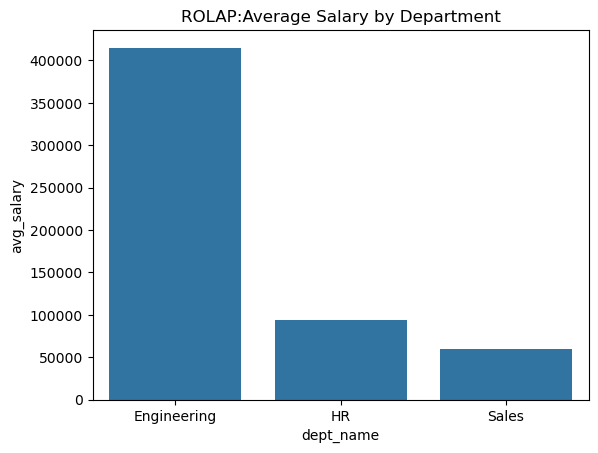

In [3]:
# Perform OLAP operations

#ROLAP Operations
query= """
SELECT d.dept_name, AVG(e.salary) as avg_salary
FROM employees e
JOIN departments d ON e.dept_id = d.dept_id
GROUP BY d.dept_name

"""

rolap_result= pd.read_sql_query(query, conn)
print("\nROLAP result (SQL aggreagation):")
print(rolap_result)

#Visualization :Roll ip by dept
sns.barplot(data=rolap_result, x='dept_name', y='avg_salary')
plt.title("ROLAP:Average Salary by Department")
plt.show()


MOLAP Cube (Department vs Age)
age                24       25       30       40        45       66
dept_name                                                          
Engineering  750000.0  80000.0      0.0      0.0       0.0      0.0
HR                0.0      0.0  70000.0  90000.0  120000.0      0.0
Sales             0.0      0.0      0.0      0.0       0.0  60000.0


C:\Users\aimmu\AppData\Local\Temp\ipykernel_23348\2460197229.py:4: FutureWarning: The provided callable <function mean at 0x0000020168F32CA0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  molap_cube=pd.pivot_table(


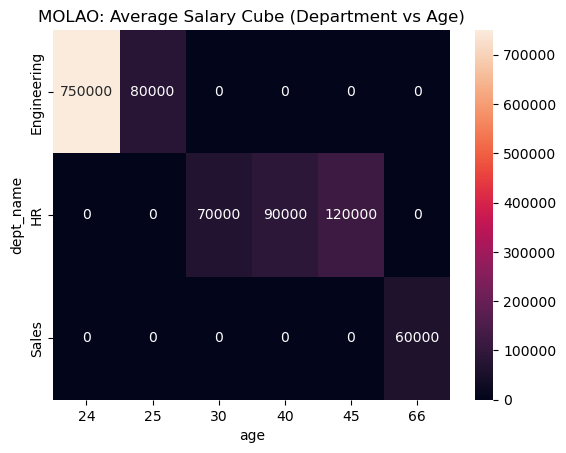


HOLAP Summary (Departments vs Age):
     dept_name         salary
0  Engineering  415000.000000
1           HR   93333.333333
2        Sales   60000.000000


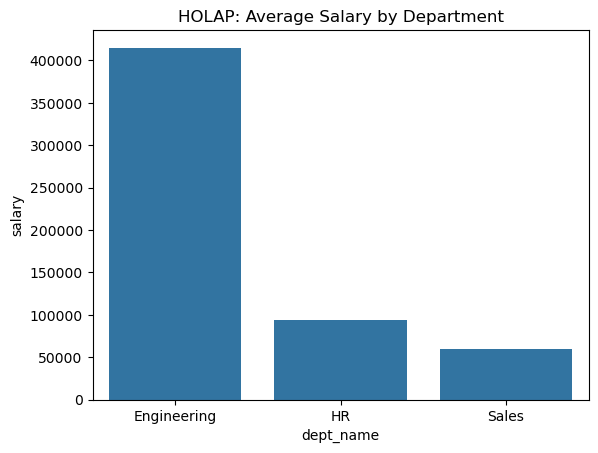


Slice (IT Department):
Empty DataFrame
Columns: [name, dept_name, salary]
Index: []

Dice (HR Department with Salary > 60000):
      name dept_name  salary
0     Mark        HR   70000
2  Charlie        HR  120000
5  Gabriel        HR   90000


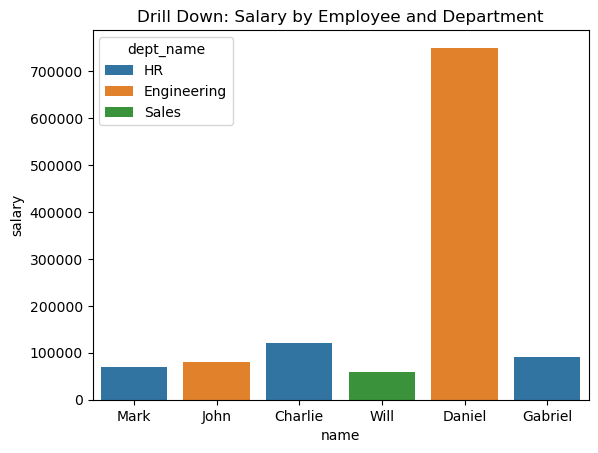


Roll Up (Total Salary by Department):
     dept_name  salary
0  Engineering  830000
1           HR  280000
2        Sales   60000


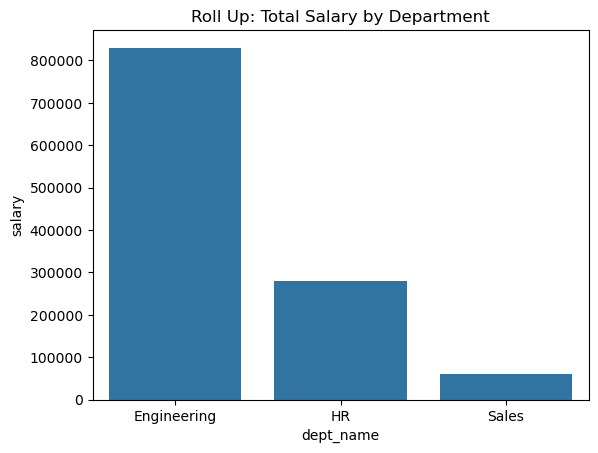

In [4]:
#MOLAP Operation
# Using Pandas for in memeory aggregation

molap_cube=pd.pivot_table(
    employees.merge(departments, on='dept_id'),
    values = 'salary',
    index='dept_name',
    columns='age',
    aggfunc=np.mean,
    fill_value=0
)

print("\nMOLAP Cube (Department vs Age)")
print(molap_cube)

#Visualization :MOLAP cube heatmap
sns.heatmap(molap_cube, annot=True, fmt=".0f")
plt.title("MOLAO: Average Salary Cube (Department vs Age)")
plt.show()

#MOLAP Operations
# Combining MOLAP and ROLAP

detail_sql = """
SELECT e.name, d.dept_name,e.salary
FROM employees e
JOIN departments d ON e.dept_id = d.dept_id
"""

detail_df = pd.read_sql_query(detail_sql, conn)
# Pandas MOLAP aggregation
holap_summary = detail_df.groupby('dept_name')['salary'].mean().reset_index()

print("\nHOLAP Summary (Departments vs Age):")
print(holap_summary)


#visualization :HOLAP summary
sns.barplot(data=holap_summary, x='dept_name', y='salary')
plt.title("HOLAP: Average Salary by Department")
plt.show()


#OLAP operations demonstrated: ROLAP, MOLAP, HOLAP

#slice
slice_df=detail_df[detail_df['dept_name']=='IT']
print("\nSlice (IT Department):")
print(slice_df)


#dice
dice_df=detail_df[(detail_df['dept_name']=='HR') & (detail_df['salary']>60000)]
print("\nDice (HR Department with Salary > 60000):")
print(dice_df)


#drill down

sns.barplot(data=detail_df, x='name', y='salary', hue='dept_name')
plt.title("Drill Down: Salary by Employee and Department")
plt.show()



#rollup
rollup_df=detail_df.groupby('dept_name')['salary'].sum().reset_index()
print("\nRoll Up (Total Salary by Department):")
print(rollup_df)

#visualization :rollup
sns.barplot(data=rollup_df, x='dept_name', y='salary')
plt.title("Roll Up: Total Salary by Department")
plt.show()

# Close the database connection
conn.close()


